In [1]:
import os
import json

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import hydra

from dataset import ImageDatasetJson
from transforms import get_transform

## Size of dataset

In [2]:
dataset_keys = ("train", "val", "test")
dataset_sizes = dict()
for dataset in dataset_keys:
    with open(f"data/splits/{dataset}.txt") as f:
        size = len(f.readlines())
        dataset_sizes[dataset] = size

print(f"total size: {sum(dataset_sizes.values())}")
print(dataset_sizes)

total size: 52453
{'train': 36589, 'val': 5320, 'test': 10544}


## Labels

In [3]:
labels = dict()
for fname in tqdm(list(os.listdir(os.path.join("data", "annotations")))):
    with open(os.path.join("data", "annotations", fname), "r") as fid:
        anno = json.load(fid)
        for obj in anno["objects"]:
            label = obj["label"]
            if label in labels:
                labels[label] += 1
            else:
                labels[label] = 1

100%|██████████| 41909/41909 [00:04<00:00, 9997.50it/s] 


In [4]:
print(f"total number of signs: {sum(labels.values())}")
print(f"number of unique labels: {len(labels)}")

total number of signs: 206386
number of unique labels: 401


### Distribution

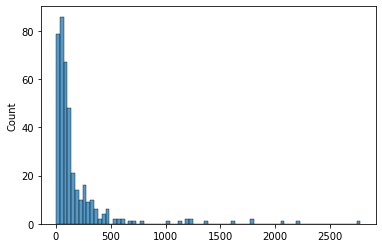

In [5]:
sorted_labels = sorted(labels.items(), key=lambda x: -x[1])
sns.histplot(x=dict(sorted_labels[1:]).values())
plt.show()

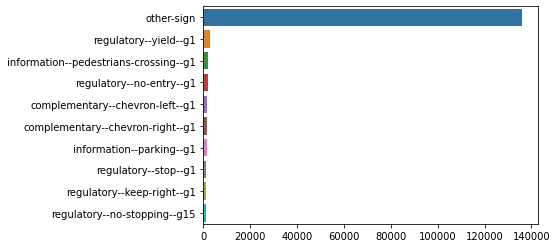

In [6]:
def make_plot(sorted_labels):
    y, x = list(zip(*sorted_labels))
    sns.barplot(x=list(x), y=list(y))
    plt.show()


make_plot(sorted_labels[:10])

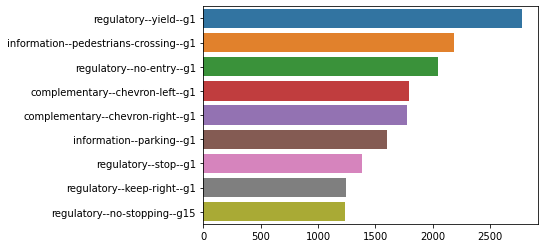

In [7]:
make_plot(sorted_labels[1:10])

how many labels occur more than 100 times

In [8]:
np.sum(np.array(list(labels.values())) > 100)

177

## Size of images

In [17]:
with hydra.initialize(config_path="HydraNet/conf"):
    cfg = hydra.compose(config_name="config.yaml")
    cfg_dataset = cfg.train.dataset
    cfg_dataset.img_dir = 'data/images/train'
    cfg_dataset.anno_dir = 'data/annotations'
    myDataset = ImageDatasetJson(cfg=cfg_dataset, transform=get_transform(True))
    myDataset_no_transform = ImageDatasetJson(cfg=cfg.train.dataset)
    print(len(myDataset))
    print(len(myDataset_no_transform))


1043
1043


### With transformations

torch.Size([3, 640, 640])


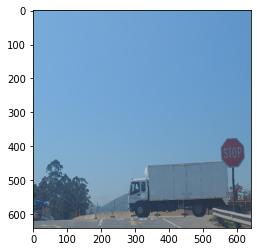

torch.Size([3, 640, 640])


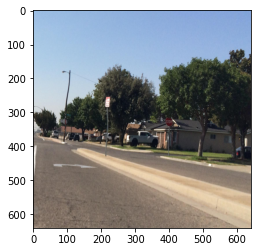

In [13]:
for i in range(2):
    img, target = myDataset[i]
    print(img.shape)
    plt.imshow(img.permute(1,2,0))
    plt.show()

### Without transformations

torch.Size([2340, 4160, 3])


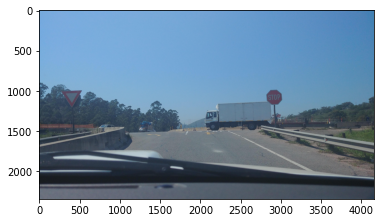

torch.Size([2448, 3264, 3])


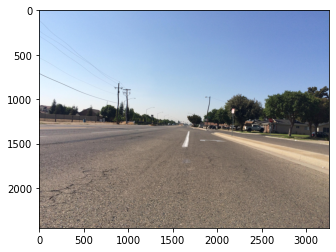

In [12]:
for i in range(2):
    img, target = myDataset_no_transform[i]
    print(img.shape)
    plt.imshow(img)
    plt.show()

In [18]:
img, target = myDataset[0]
target

{'boxes': tensor([[403.7449, 263.4830, 467.0867, 352.2008]]),
 'labels': tensor([1], dtype=torch.int32),
 'area': tensor([5619.5503]),
 'image_id': tensor([0])}